Получение исходных данных

In [14]:
from basepolygon_class import GoalPolygon

place = GoalPolygon('Жилой комплекс «Одинцово-1»')
v = place.polygon

/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


Геометрическое упрощение

In [15]:
def get_xy(s):
    x, y = s.centroid.coords.xy
    return x[0], y[0]

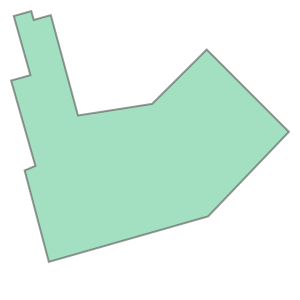

In [16]:
from shapely.affinity import translate

s = v.simplify(10, preserve_topology=True)
x, y = get_xy(s)
st = translate(s, 0-x, 0-y)

st

In [17]:
# убрать бы эту ебань
coor_list = (list(st.boundary.coords[0:len(st.boundary.coords) - 1]))
print (coor_list)

[(-457.0172720781993, 258.97449130937457), (-366.09260647476185, -60.90662323217839), (-406.370928882272, -78.09141644276679), (-315.6018337655696, -420.78100279252976), (281.6218242336181, -250.27657229732722), (584.4998824985232, 66.75690660160035), (276.3574749503168, 375.1489524655044), (71.72904935956467, 171.57023276295513), (-206.33228341693757, 128.09713660832494), (-308.2299947499996, 504.2544806478545), (-372.1630306050647, 486.3254869300872), (-381.4635806995793, 519.34869635012), (-447.171697431535, 500.9196722963825), (-384.71937846927904, 279.24263294879347)]


Декомпозиция периметра

In [18]:
import numpy as np
from math import pi, cos, sin

target = pi/2
basis = np.array([[1, 0, 0],[0, 1, 0]])
tolerance=0.75

In [19]:
transform = np.array(
    [
        [cos(target), -sin(target), 0],
        [sin(target), cos(target), 0],
        [0, 0, 1]
    ]
)
transform

array([[ 6.123234e-17, -1.000000e+00,  0.000000e+00],
       [ 1.000000e+00,  6.123234e-17,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [20]:
metric = np.complex(np.cross(basis[0], basis[1])[-1],
                             np.cross(basis[1], basis[0])[-1])


/var/folders/l7/52t7xngd2973k8x9_y55rmyh0000gn/T/ipykernel_31033/2402548898.py:1: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metric = np.complex(np.cross(basis[0], basis[1])[-1],


In [21]:
from itertools import islice, cycle

def vec_search(point_list, key):
    cr = []
    n = list(islice(cycle(range(len(point_list))), 0, len(point_list) + 2))
    for i in range(len(point_list)):
        v_one = [point_list[n[i]][0] - point_list[n[i + 1]][0], point_list[n[i]][1] - point_list[n[i + 1]][1], 0]
        v_two = [point_list[n[i + 1]][0] - point_list[n[i + 2]][0], point_list[n[i + 1]][1] - point_list[n[i + 2]][1],0]
        v_o_norm, v_t_norm = v_one / np.linalg.norm(v_one), v_two / np.linalg.norm(v_two)
        if np.cross(v_o_norm, v_t_norm)[2] < key:
            cr.append(n[i + 1])
        else:
            pass
    cross = [*cr, cr[0] + cr[-1] + 1]
    double_points = [*range(len(point_list)), *range(len(point_list))]
    segments = [double_points[cross[c]:cross[c + 1]+1] for c in range(len(cross) - 1)]
    return segments

In [22]:
bb = vec_search(coor_list, 0.7)
print(bb)

[[1, 2, 3, 4], [4, 5, 6, 7], [7, 8], [8, 9, 10], [10, 11, 12, 13], [13, 0, 1]]


In [23]:
def chains (point_list):
    key_val = vec_search(point_list, 0.7)
    vectors =[]
    for i in key_val:
        temp =[]
        for l in range(len(i)-1):
            vec = [point_list[i[l]][0] - point_list[i[l+1]][0], point_list[i[l]][1] - point_list[i[l+1]][1]]
            temp.append(vec)
        vectors.append(temp)
    return vectors



In [24]:
res_vec = chains(coor_list)
print(res_vec)

[[[40.27832240751013, 17.184793210588396], [-90.76909511670237, 342.689586349763], [-597.2236579991877, -170.50443049520254]], [[-302.8780582649051, -317.03347889892757], [308.1424075482064, -308.39204586390406], [204.62842559075216, 203.57871970254928]], [[278.06133277650224, 43.473096154630184]], [[101.89771133306203, -376.15734403952956], [63.9330358550651, 17.928993717767298]], [[9.30055009451462, -33.0232094200328], [65.70811673195567, 18.42902405373752], [-62.45231896225596, 221.67703934758902]], [[72.29789360892028, 20.2681416394189], [-90.92466560343746, 319.88111454155296]]]


SVD
Декомпозиция

In [25]:
# Это техническая часть для работы с локальными данными
import json

f = open("/Users/andrewastakhov/dumps/pl.json", "r")
points = json.load(f)['pts']

FileNotFoundError: [Errno 2] No such file or directory: '/Users/andrewastakhov/dumps/pl.json'

In [26]:
from scipy.linalg import svd
import numpy as np

A = np.asarray(res_vec)

/var/folders/l7/52t7xngd2973k8x9_y55rmyh0000gn/T/ipykernel_31033/1396746674.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.asarray(res_vec)


In [27]:
print(A)

[list([[40.27832240751013, 17.184793210588396], [-90.76909511670237, 342.689586349763], [-597.2236579991877, -170.50443049520254]])
 list([[-302.8780582649051, -317.03347889892757], [308.1424075482064, -308.39204586390406], [204.62842559075216, 203.57871970254928]])
 list([[278.06133277650224, 43.473096154630184]])
 list([[101.89771133306203, -376.15734403952956], [63.9330358550651, 17.928993717767298]])
 list([[9.30055009451462, -33.0232094200328], [65.70811673195567, 18.42902405373752], [-62.45231896225596, 221.67703934758902]])
 list([[72.29789360892028, 20.2681416394189], [-90.92466560343746, 319.88111454155296]])]


Пример с одной матрицей

In [28]:
a = np.asarray(A[0])

In [29]:
a

array([[  40.27832241,   17.18479321],
       [ -90.76909512,  342.68958635],
       [-597.223658  , -170.5044305 ]])

In [30]:
U, s, Vh=svd(a)

In [31]:
s

array([622.66245335, 354.44628545])

Получить Sigma из s Хуй знает зачем сайпи говорят что это полезно

In [32]:
sigma = np.zeros(a.shape)
for i in range(min(a.shape)):
            sigma[i, i] = s[i]
sigma

array([[622.66245335,   0.        ],
       [  0.        , 354.44628545],
       [  0.        ,   0.        ]])

А точно, как минимум для обратной проверки, "B" должно быть равно "a"

In [33]:
B = U @ sigma @ Vh

In [34]:
a

array([[  40.27832241,   17.18479321],
       [ -90.76909512,  342.68958635],
       [-597.223658  , -170.5044305 ]])

In [35]:
B

array([[  40.27832241,   17.18479321],
       [ -90.76909512,  342.68958635],
       [-597.223658  , -170.5044305 ]])

Теперь на торче
Класс треннируется на основе отсортированых данных выпуклой декомпозиции периметра


In [36]:
import torch
from polygon_division import vector_search, points_to_point_chain

/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


[[1, 2, 3], [4, 5, 6], [7], [8, 9], [10, 11, 12], [13, 0]]


/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [37]:
class SvdItem:
    keys=["A", "U", "S", "Vh", "Sigma"]
    def __init__(self, m, collection=None, **kwargs):
        self.A = torch.tensor(m)
        self.collection=collection
        self.U = None
        self.S = None
        self.Vh = None
        self.Sigma = None
        self.svd(**kwargs)
        if collection is not None:
            self.id = f'{collection.id}:{len(collection.matrices)}'
            print(f'set item id: {self.id}')
            collection.A.append(self.A)



    def svd(self, **kwargs):
        U, S, Vh = torch.linalg.svd(self.A, **kwargs)
        Sigma = torch.diag(S)
        self.U, self.S, self.Vh, self.Sigma=U, S, Vh, Sigma
        print(self.U, self.S, self.Vh, self.Sigma)
        if self.collection:
            for v, k in zip([A, U, S, Vh, Sigma], self.__class__.keys):
                (self.collection.__dict__[k]).append(v)

        return U, S, Vh, Sigma
    def pack(self):
        self.collection.__dict__[self.__class__.__name__][self.collection.id]|={self.id:self}
        return self.id, self



class SvdPack:
    def __init__(self):
        self._matrices = []
        self.id = f'{0}:{0}'
        self.A, self.U, self.S, self.Vh, self.Sigma = [], [], [], [], []
        self.tree= {self.id:{}}



    @property
    def matrices(self):
        return self._matrices
    @matrices.setter
    def matrices(self, val, **kwargs):
        if len(val.shape) == 2:
            self._matrices.append(SvdItem(val, collection=self, **kwargs))
        else:
            for v in val:
                self._matrices.append(SvdItem(v, collection=self, **kwargs))


In [38]:
pck = SvdPack()

In [39]:
a_=np.asarray(res_vec, dtype=object)

In [40]:
len(a_.shape)

1

In [41]:
pck.matrices = a_

tensor([[-0.0699, -0.0142,  0.9975],
        [-0.0167, -0.9997, -0.0154],
        [ 0.9974, -0.0177,  0.0696]]) tensor([622.6624, 354.4463]) tensor([[-0.9588, -0.2842],
        [ 0.2842, -0.9588]]) tensor([[622.6624,   0.0000],
        [  0.0000, 354.4463]])
set item id: 0:0:0
tensor([[-0.8348,  0.0270,  0.5499],
        [-0.0416, -0.9990, -0.0140],
        [ 0.5490, -0.0346,  0.8351]]) tensor([525.0457, 435.8289]) tensor([[ 0.6711,  0.7413],
        [-0.7413,  0.6711]]) tensor([[525.0457,   0.0000],
        [  0.0000, 435.8289]])
set item id: 0:0:1
tensor([[-1.]]) tensor([281.4392]) tensor([[-0.9880, -0.1545],
        [-0.1545,  0.9880]]) tensor([[281.4392]])
set item id: 0:0:2
tensor([[-1.0000,  0.0016],
        [ 0.0016,  1.0000]]) tensor([389.7151,  66.3967]) tensor([[-0.2612,  0.9653],
        [ 0.9653,  0.2612]]) tensor([[389.7151,   0.0000],
        [  0.0000,  66.3967]])
set item id: 0:0:3
tensor([[ 1.4734e-01, -9.6023e-05,  9.8909e-01],
        [ 3.7345e-04,  1.0000e+00,  4.14

In [42]:
pck.matrices

In [43]:
pck.S

[tensor([622.6624, 354.4463]),
 tensor([525.0457, 435.8289]),
 tensor([281.4392]),
 tensor([389.7151,  66.3967]),
 tensor([232.8477,  68.2435]),
 tensor([332.5527,  75.0847])]

In [44]:
pck.Vh

[tensor([[-0.9588, -0.2842],
         [ 0.2842, -0.9588]]),
 tensor([[ 0.6711,  0.7413],
         [-0.7413,  0.6711]]),
 tensor([[-0.9880, -0.1545],
         [-0.1545,  0.9880]]),
 tensor([[-0.2612,  0.9653],
         [ 0.9653,  0.2612]]),
 tensor([[ 0.2713, -0.9625],
         [ 0.9625,  0.2713]]),
 tensor([[-0.2736,  0.9618],
         [ 0.9618,  0.2736]])]

РАЗГРУППИРОВКА ТОЧЕК ПО ПАТТЕРНУ

In [55]:
def transform_chains_vh(chains, t):
    chains_t=[]
    for i, clust in enumerate(chains):
        _t=[]
        for j in clust:
            _ = t.Vh[i] @ np.asarray(coor_list[j])
            _t.append(np.asarray(_).tolist())
        chains_t.append(_t)
    return chains_t

p_t = transform_chains_vh(bb, pck)
p_t

[[[368.3054003024502, -45.65675417309674],
  [411.80687843330503, -40.62866426698649],
  [422.18108440780776, 313.7264562497931],
  [-198.873269642217, 319.9978605911334]],
 [[3.466789598022558, -376.74548679605425],
  [441.7668454480328, -388.5081317087156],
  [463.58430617634554, 46.90127341098551],
  [175.33100673587978, 61.97121160859862]],
 [[-97.37010413539976, 158.43126050821317],
  [184.06906850276968, 158.43125584904223]],
 [[177.54621018139653, -165.70830782356637],
  [567.2608653059561, -165.8116259538253],
  [566.6543891344328, -232.20827501259285]],
 [[-569.0476071326293, -226.2801235668514],
  [-603.3555184424306, -226.27357535494124],
  [-603.4424658548237, -294.5171016245942],
  [-373.1361228758772, -294.541891708759]],
 [[373.8473159694825, -293.63862585968434],
  [374.13332929409944, -368.7232543289264],
  [41.58074248495152, -368.7878268537669]]]

ЦЕПОЧКИ ВЕКТОРОВ (ВХОДЯТ ТОЧКИ С ЗАДАННЫМ ПАТТЕРНОМ)

In [57]:
def chains_ (point_list):
    vectors =[]
    for i in point_list:
        temp =[]
        for l in range(len(i)-1):
            vec = [i[l][0] - i[l+1][0], i[l][1] - i[l+1][1]]
            temp.append(vec)
        vectors.append(temp)
    return vectors

v_t = chains_(p_t)
# not transformed vec
v_ = res_vec

[[[-43.50147813085482, -5.028089906110253],
  [-10.374205974502729, -354.3551205167796],
  [621.0543540500248, -6.271404341340315]],
 [[-438.30005585001027, 11.762644912661358],
  [-21.81746072831271, -435.4094051197011],
  [288.25329944046575, -15.069938197613112]],
 [[-281.43917263816945, 4.659170940612967e-06]],
 [[-389.7146551245596, 0.10331813025894121],
  [0.6064761715233544, 66.39664905876754]],
 [[34.307911309801284, -0.006548211910143209],
  [0.08694741239310133, 68.24352626965296],
  [-230.30634297894647, 0.024790084164806103]],
 [[-0.2860133246169312, 75.08462846924203],
  [332.5525868091479, 0.06457252484051423]]]

In [47]:
def angle(a, b):
    return np.arccos(a @ b)

for i, v_ in enumerate(aa):
    va = np.asarray(v_)
    vb = np.asarray(res_vec[i])
    print(angle(va[1], vb[1]))






nan
nan


/var/folders/l7/52t7xngd2973k8x9_y55rmyh0000gn/T/ipykernel_31033/100423700.py:2: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(a @ b)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [59]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))


ang =[]
for j, i in enumerate(v_t):
    for ind, val in enumerate(i):
        ang.append(angle_between(val, v_[j][ind]))

print(ang)



[2.853397993066149, 2.8533979930661486, 2.853397993066149, 0.8350593062280169, 0.8350593062280172, 0.8350593062280173, 2.9865045749685875, 1.8356037255880773, 1.288251384035326, 1.2960796257017289, 1.2960796257017284, 1.2960796257017289, 1.3012796385487626, 1.8475430589666424]


In [60]:
for i in pck.Vh:
    for j in pck.Vh:

        print(torch.dist(i, j, p=4), torch.dist(i, j, p=2))
        print(i@j.T)
    print('end\n')


tensor(0.) tensor(0.)
tensor([[1., 0.],
        [0., 1.]])
tensor(2.0101) tensor(2.7234)
tensor([[-0.8542,  0.5200],
        [-0.5200, -0.8542]])
tensor(1.9480) tensor(2.)
tensor([[ 0.9912, -0.1327],
        [-0.1327, -0.9912]])
tensor(1.5031) tensor(2.)
tensor([[-0.0239, -0.9997],
        [-0.9997,  0.0239]])
tensor(1.4955) tensor(1.9865)
tensor([[ 0.0135, -0.9999],
        [ 0.9999,  0.0135]])
tensor(1.5063) tensor(2.0000)
tensor([[-0.0111, -0.9999],
        [-0.9999,  0.0111]])
end

tensor(2.0101) tensor(2.7234)
tensor([[-0.8542, -0.5200],
        [ 0.5200, -0.8542]])
tensor(0.) tensor(0.)
tensor([[1.0000, 0.0000],
        [0.0000, 1.0000]])
tensor(1.6999) tensor(2.0000)
tensor([[-0.7776,  0.6288],
        [ 0.6288,  0.7776]])
tensor(1.7449) tensor(2.0000)
tensor([[ 0.5403,  0.8415],
        [ 0.8415, -0.5403]])
tensor(2.0278) tensor(2.4751)
tensor([[-0.5315,  0.8471],
        [-0.8471, -0.5315]])
tensor(1.7434) tensor(2.0000)
tensor([[ 0.5294,  0.8484],
        [ 0.8484, -0.5294]])

In [61]:
pck.U

[tensor([[-0.0699, -0.0142,  0.9975],
         [-0.0167, -0.9997, -0.0154],
         [ 0.9974, -0.0177,  0.0696]]),
 tensor([[-0.8348,  0.0270,  0.5499],
         [-0.0416, -0.9990, -0.0140],
         [ 0.5490, -0.0346,  0.8351]]),
 tensor([[-1.]]),
 tensor([[-1.0000,  0.0016],
         [ 0.0016,  1.0000]]),
 tensor([[ 1.4734e-01, -9.6023e-05,  9.8909e-01],
         [ 3.7345e-04,  1.0000e+00,  4.1436e-05],
         [-9.8909e-01,  3.6332e-04,  1.4734e-01]]),
 tensor([[-8.6005e-04,  1.0000e+00],
         [ 1.0000e+00,  8.6007e-04]])]

In [62]:
for i in pck.matrices:
    print(i.U[:,:2],'\n' ,i.S,'\n', i.Vh, '\n')

tensor([[-0.0699, -0.0142],
        [-0.0167, -0.9997],
        [ 0.9974, -0.0177]]) 
 tensor([622.6624, 354.4463]) 
 tensor([[-0.9588, -0.2842],
        [ 0.2842, -0.9588]]) 

tensor([[-0.8348,  0.0270],
        [-0.0416, -0.9990],
        [ 0.5490, -0.0346]]) 
 tensor([525.0457, 435.8289]) 
 tensor([[ 0.6711,  0.7413],
        [-0.7413,  0.6711]]) 

tensor([[-1.]]) 
 tensor([281.4392]) 
 tensor([[-0.9880, -0.1545],
        [-0.1545,  0.9880]]) 

tensor([[-1.0000,  0.0016],
        [ 0.0016,  1.0000]]) 
 tensor([389.7151,  66.3967]) 
 tensor([[-0.2612,  0.9653],
        [ 0.9653,  0.2612]]) 

tensor([[ 1.4734e-01, -9.6023e-05],
        [ 3.7345e-04,  1.0000e+00],
        [-9.8909e-01,  3.6332e-04]]) 
 tensor([232.8477,  68.2435]) 
 tensor([[ 0.2713, -0.9625],
        [ 0.9625,  0.2713]]) 

tensor([[-8.6005e-04,  1.0000e+00],
        [ 1.0000e+00,  8.6007e-04]]) 
 tensor([332.5527,  75.0847]) 
 tensor([[-0.2736,  0.9618],
        [ 0.9618,  0.2736]]) 



In [63]:
pck.tree

{'0:0': {}}

In [64]:
pck.matrices